In [1]:
from numpy.core.umath_tests import matrix_multiply as mm
from scipy.stats import multivariate_normal as mvn
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from sklearn import cluster
import pandas as pd
import numpy as np
import random
%matplotlib inline

In [2]:
# Read and parse data
DATA_SET = pd.read_csv("data/faithful.txt", sep="\s+")

In [3]:
# Linearly scale data to [0,1]
def rescale (data):
    max = np.max(data)
    min = np.min(data)
    return (data - min)/(max - min)

In [4]:
# Preprocess the data set
DATA_SET['eruptions'] = rescale(DATA_SET['eruptions'])
DATA_SET['waiting'] = rescale(DATA_SET['waiting'])

In [5]:
# Plot features
def plot_features (data):
    plt.scatter(data['eruptions'], data['waiting'], c='g', alpha=0.5)
    plt.title('Old Faithful Geyser Data')
    plt.xlabel('Eruptions Time (min)')
    plt.ylabel('Waiting Time (min)')
    plt.axis([0,1,0,1])

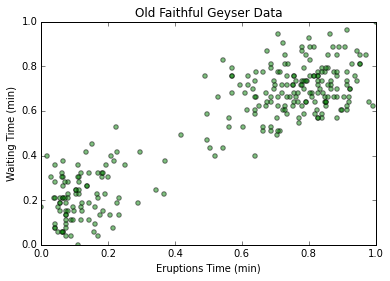

In [6]:
plot_features(DATA_SET)

In [7]:
features = np.asarray([row for row in DATA_SET.itertuples(index=False)])

In [8]:
class GMM:
    def __init__ (self, k):
        self.k = k # number of clusters
        self.trajectory = [] # keep track of means over iterations
        
    def initialize_params (self, X):
        n, p = X.shape # dimensions
        mu = X[np.random.choice(n, self.k, False)]
        sigma = [random.random()*np.identity(p) for i in range(self.k)]
        pi = [0.5, 0.5]
        return [mu, sigma, pi]
        
    def fit (self, X, mu, sigma, pi, max_iter=100, tolerance=0.01):  
        # Dimensions
        n, p = X.shape
        k = self.k
        
        # Keep track of log likelihood for convergence purposes
        log_likelihood_old, log_likelihood_new = 0, 0
        
        for i in range(max_iter):            
            # E-Step
            resp = np.zeros((k, n))
            for mode in range(k):
                resp[mode] = pi[mode] * mvn(mu[mode], sigma[mode]).pdf(X)
            resp /= resp.sum(0)
            
            # M-Step
            pi = resp.sum(axis=1) / n
            mu = np.asarray([np.dot(r,X) / r.sum() for r in resp])
            
            # Sigma implementation adapted from Ref.8
            sigma = np.zeros((k, p, p))
            for j in range(k):
                Y = X - mu[j, :]
                sigma[j] = (resp[j,:,None,None] * mm(Y[:,:,None], Y[:,None,:])).sum(axis=0)
            sigma /= resp.sum(axis=1)[:,None,None]
                        
            # Track trajectory of means against iteration
            self.trajectory.append(mu)
            
            # Update log likelihood and check for convergence
            log_likelihood_new =  np.sum([P * mvn(M, S).pdf(X) for P,M,S in zip(pi, mu, sigma)], axis=0)
            log_likelihood_new = np.log(log_likelihood_new).sum()
            if np.abs(log_likelihood_new - log_likelihood_old) < tolerance:
                break
            
            # Otherwiae, keep updated value for next iteration
            log_likelihood_old = log_likelihood_new
            
        return [mu, sigma, pi]

In [9]:
# Imeplementation adapted from Ref.9
def plot_gaussian (mean, cov, std=2):
    # Eigensort
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Calculate width and height of the ellipse
    width, height = 2 * std * np.sqrt(abs(vals))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, facecolor='none')

    # Draw the ellipse
    ax = plt.gca()
    ax.add_artist(ellipse)
    plt.axis([0,1,0,1])

In [10]:
def fit (self, X, mu, sigma, pi, max_iter=100, tolerance=0.01):  
    # Dimensions
    n, p = X.shape
    k = self.k

    # Keep track of log likelihood for convergence purposes
    log_likelihood_old, log_likelihood_new = 0, 0

    for i in range(max_iter):            
        # E-Step
        resp = np.zeros((k, n))
        for mode in range(k):
            resp[mode] = pi[mode] * mvn(mu[mode], sigma[mode]).pdf(X)
        resp /= resp.sum(0)

        # M-Step
        pi = resp.sum(axis=1) / n
        mu = np.asarray([np.dot(r,X) / r.sum() for r in resp])

        # Sigma implementation adapted from Ref.4
        sigma = np.zeros((k, p, p))
        for j in range(k):
            Y = X - mu[j, :]
            sigma[j] = (resp[j,:,None,None] * mm(Y[:,:,None], Y[:,None,:])).sum(axis=0)
        sigma /= resp.sum(axis=1)[:,None,None]

        # Track trajectory of means against iteration
        self.trajectory.append(mu)

        # Update log likelihood and check for convergence
        log_likelihood_new =  np.sum([P * mvn(M, S).pdf(X) for P,M,S in zip(pi, mu, sigma)], axis=0)
        log_likelihood_new = np.log(log_likelihood_new).sum()
        if np.abs(log_likelihood_new - log_likelihood_old) < tolerance:
            break

        # Otherwiae, keep updated value for next iteration
        log_likelihood_old = log_likelihood_new

In [11]:
# Repeat 50 trials
mu, sigma, pi, total_iterations = [], [], [], []
for trial in range(50):
    g = GMM(2)
    m, s, p = g.initialize_params(features)
    mu, sigma, pi = g.fit(features, m, s, p)
    total_iterations.append(len(g.trajectory))

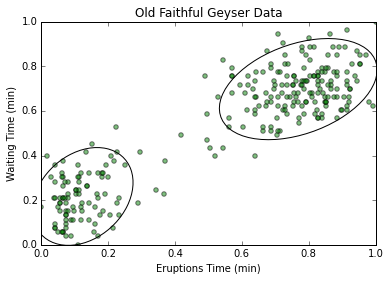

In [12]:
# Plot Gaussians against data set
plot_features(DATA_SET)
plot_gaussian(mu[0], sigma[0])
plot_gaussian(mu[1], sigma[1])

In [13]:
def plot_trajectory_freq(total_iterations):
    plt.hist(total_iterations)
    plt.title('Distribution of Iteration Frequency')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Frequency')
    plt.show()
    return

In [14]:
def plot_trajectories (data, color, name):
    plt.scatter(data['x'], data['y'], c=color, label=name)
    plt.title("Mean Trajectories")
    plt.xlabel("Erruption Time (min)")
    plt.ylabel('Waiting Time (min)')
    plt.axis([0,1,0,1])
    plt.legend(loc=4)
    labels = data.index.values
    for label, x, y in zip(labels, data['x'], data['y']):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )
    return

In [15]:
mode_one, mode_two = [], []
for iter in g.trajectory:
    mode_one.append(iter[0])
    mode_two.append(iter[1])
    
mode_one = pd.DataFrame(mode_one, columns=["x","y"])
mode_two = pd.DataFrame(mode_two, columns=["x","y"])

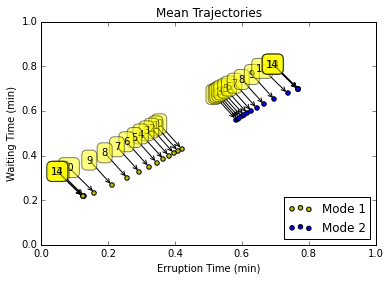

In [16]:
# Plot trajectories of the means of each Gaussian
plot_trajectories(mode_one, 'y', "Mode 1")
plot_trajectories(mode_two, 'b', "Mode 2")

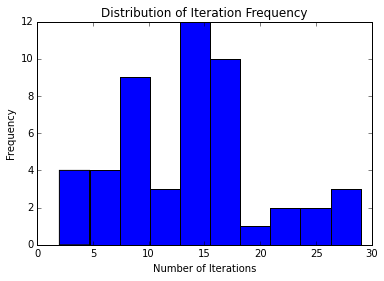

In [17]:
plot_trajectory_freq(total_iterations)

In [18]:
# Repeat 50 trials
k_mu, k_sigma, k_pi, k_total_iterations = [], [], [], []
for trial in range(50):
    # Get initial params from K-Means clustering
    k = cluster.KMeans(2).fit(features)
    k_m = k.cluster_centers_
    k_s = [np.cov(k.predict(features))*np.identity(2) for i in range(2)]
    k_p = [0.5, 0.5]
    
    k_g = GMM(2)
    k_mu, k_sigma, k_pi = k_g.fit(features, k_m, k_s, k_p)
    k_total_iterations.append(len(k_g.trajectory))

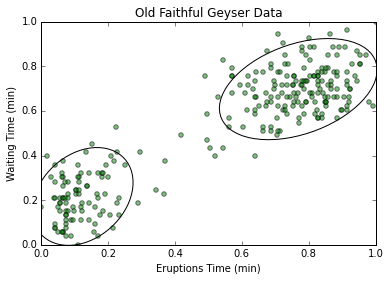

In [19]:
# Plot Gaussians against data set
plot_features(DATA_SET)
plot_gaussian(k_mu[0], k_sigma[0])
plot_gaussian(k_mu[1], k_sigma[1])

In [20]:
k_mode_one, k_mode_two = [], []
for iter in k_g.trajectory:
    k_mode_one.append(iter[0])
    k_mode_two.append(iter[1])    
    
k_mode_one = pd.DataFrame(k_mode_one, columns=["x","y"])
k_mode_two = pd.DataFrame(k_mode_two, columns=["x","y"])

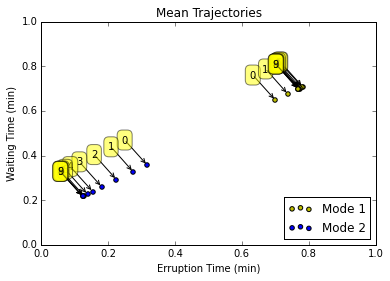

In [21]:
# Plot trajectories of the means of each Gaussian
plot_trajectories(k_mode_one, 'y', "Mode 1")
plot_trajectories(k_mode_two, 'b', "Mode 2")

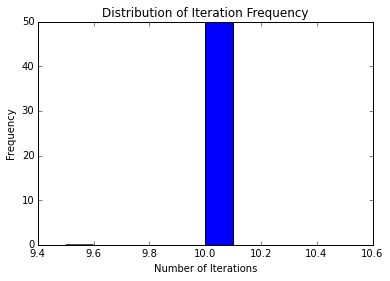

In [22]:
plot_trajectory_freq(k_total_iterations)